In [1]:
%pylab inline

import matplotlib as pyplot
import os
import pandas as pd

#FEATUREDIR = "/storage/mgymrek/gtex/causality/features/"
FEATUREDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
SCORETYPE = ""
MINDIST = 1500
MINQ = 1
percentiles = [0, 50] + list(np.arange(60, 101, 10))


def GetBootstrapCI(data, func):
    numiter = 1000
    vals = []
    for i in range(numiter):
        x = np.random.choice(data, size=data.shape[0], replace=True)
        vals.append(func(x))
    se = np.sqrt(np.var(vals))
    return np.mean(vals)-1.96*se, np.mean(vals)+1.96*se


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plot TSS/TES
data = pd.read_csv(os.path.join(FEATUREDIR, "GTEx_merged_causality_tsstes%s.tab"%SCORETYPE), sep="\t")
data = data[data["best.score"] >= 0]

bins = np.percentile(data[data["best.q"]<=MINQ]["best.score"], q = percentiles)
binlabels = []
tss = []
tss_low = []
tss_high = []
tes = []
tes_low = []
tes_high = []

for i in range(len(bins)-1):
    lb = bins[i]
    ub = bins[i+1]
    x = data[(data["best.score"]>lb) & (data["best.score"]<= ub) & (data["best.q"]<=MINQ)]
    feature_tss = x["dist.to.tss"].apply(lambda x: abs(x)<MINDIST)
    feature_tes = x["dist.to.tes"].apply(lambda x: abs(x)<MINDIST)
    count_tss = np.mean(feature_tss)
    count_tes = np.mean(feature_tes)
    low_tss, high_tss = GetBootstrapCI(feature_tss, np.mean)
    low_tes, high_tes = GetBootstrapCI(feature_tes, np.mean)
    if i == 0:
        base_tss = count_tss
        base_tes = count_tes
    binlabels.append("%s-%s"%(percentiles[i], percentiles[i+1]))
    tss.append(count_tss*1.0/base_tss)
    tss_low.append(low_tss*1.0/base_tss)
    tss_high.append(high_tss*1.0/base_tss)
    tes.append(count_tes*1.0/base_tes)
    tes_low.append(low_tes*1.0/base_tes)
    tes_high.append(high_tes*1.0/base_tes)

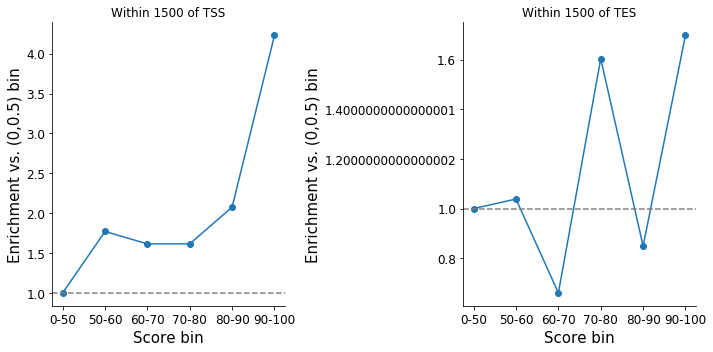

In [3]:
fig = plt.figure()
fig.set_size_inches((10, 5))

# TSS
ax = fig.add_subplot(121)
#ax.errorbar(range(len(binlabels)), tss, marker="o", yerr = [tss_low, tss_high])
ax.plot(range(len(binlabels)), tss, marker="o")
ax.set_xlabel("Score bin", size=15)
ax.set_ylabel("Enrichment vs. (0,0.5) bin", size=15)
ax.set_xticks(range(len(binlabels)))
ax.set_xticklabels(binlabels, size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.axhline(y = 1.0, linestyle="dashed", color="gray")
ax.set_title("Within %s of TSS"%MINDIST)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# TES
ax = fig.add_subplot(122)
#ax.errorbar(range(len(binlabels)), tes, marker="o", yerr = [tes_low, tes_high])
ax.plot(range(len(binlabels)), tes, marker="o")
ax.set_xlabel("Score bin", size=15)
ax.set_ylabel("Enrichment vs. (0,0.5) bin", size=15)
ax.set_xticks(range(len(binlabels)))
ax.set_xticklabels(binlabels, size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.axhline(y = 1.0, linestyle="dashed", color="gray")
ax.set_title("Within %s of TES"%MINDIST)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.tight_layout()


In [ ]:
data["abs.dist.tss"] = abs(data["dist.to.tss"])
data.sort("best.score", ascending=False)